In [1]:
from googleapiclient.discovery import build
from oauth2client.service_account import ServiceAccountCredentials

In [2]:
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [3]:
SCOPES = ['https://www.googleapis.com/auth/analytics.readonly']
KEY_FILE_LOCATION = 'client_secrets.json'   # Generate this file from Google Cloud Console for accessing Reporting API
VIEW_ID = '1234567890' # Replace with Google Analytics Main View

In [4]:
credentials = ServiceAccountCredentials.from_json_keyfile_name(KEY_FILE_LOCATION, SCOPES)

In [6]:
def ga_response_dataframe(response):
    row_list = []
    # Get each collected report
    for report in response.get('reports', []):
        # Set column headers
        column_header = report.get('columnHeader', {})
        dimension_headers = column_header.get('dimensions', [])
        metric_headers = column_header.get('metricHeader', {}).get('metricHeaderEntries', [])
    
        # Get each row in the report
        for row in report.get('data', {}).get('rows', []):
            # create dict for each row
            row_dict = {}
            dimensions = row.get('dimensions', [])
            date_range_values = row.get('metrics', [])

            # Fill dict with dimension header (key) and dimension value (value)
            for header, dimension in zip(dimension_headers, dimensions):
                row_dict[header] = dimension

            # Fill dict with metric header (key) and metric value (value)
            for i, values in enumerate(date_range_values):
                for metric, value in zip(metric_headers, values.get('values')):
                # Set int as int, float a float
                    if ',' in value or '.' in value:
                        row_dict[metric.get('name')] = float(value)
                    else:
                        row_dict[metric.get('name')] = int(value)

            row_list.append(row_dict)
    return pd.DataFrame(row_list)

In [8]:
# Build the service object.
analytics = build('analyticsreporting', 'v4', credentials=credentials)

response = analytics.reports().batchGet(body={
    'reportRequests': [{
        'viewId': VIEW_ID,
        'dateRanges': [{'startDate': '2022-01-01', 'endDate': '2022-01-31'}],
        'metrics': [
            {"expression": "ga:sessions"},
        ], "dimensions": [
            {"name": "ga:longitude"},
            {"name": "ga:latitude"}
        ], "samplingLevel": "LARGE",
        "pageSize": 10000
    }]}).execute()

df2 = ga_response_dataframe(response)
df2['ga:latitude'] = pd.to_numeric(df2['ga:latitude'])
df2['ga:longitude'] = pd.to_numeric(df2['ga:longitude'])

df2.head()

,ga:longitude,ga:latitude,ga:sessions
0,-0.1278,51.5074,9
1,-0.1870,5.6037,687
2,-0.3274,53.7676,1
3,-0.6349,35.6987,55
4,-0.7069,47.8268,1


In [9]:
import geopandas

In [10]:
gdf = geopandas.GeoDataFrame(df2, geometry=geopandas.points_from_xy(df2['ga:longitude'], df2['ga:latitude']))

In [11]:
# Top 5 locations for maximum sessions
gdf.sort_values(by="ga:sessions",ascending=False).head()

,ga:longitude,ga:latitude,ga:sessions,geometry
2461,77.2218,28.6863,290701,POINT (77.22180 28.68630)
2524,77.5946,12.9716,223025,POINT (77.59460 12.97160)
2649,78.4867,17.3850,206084,POINT (78.48670 17.38500)
2972,85.1376,25.5941,191341,POINT (85.13760 25.59410)
1803,72.8777,19.0760,189542,POINT (72.87770 19.07600)


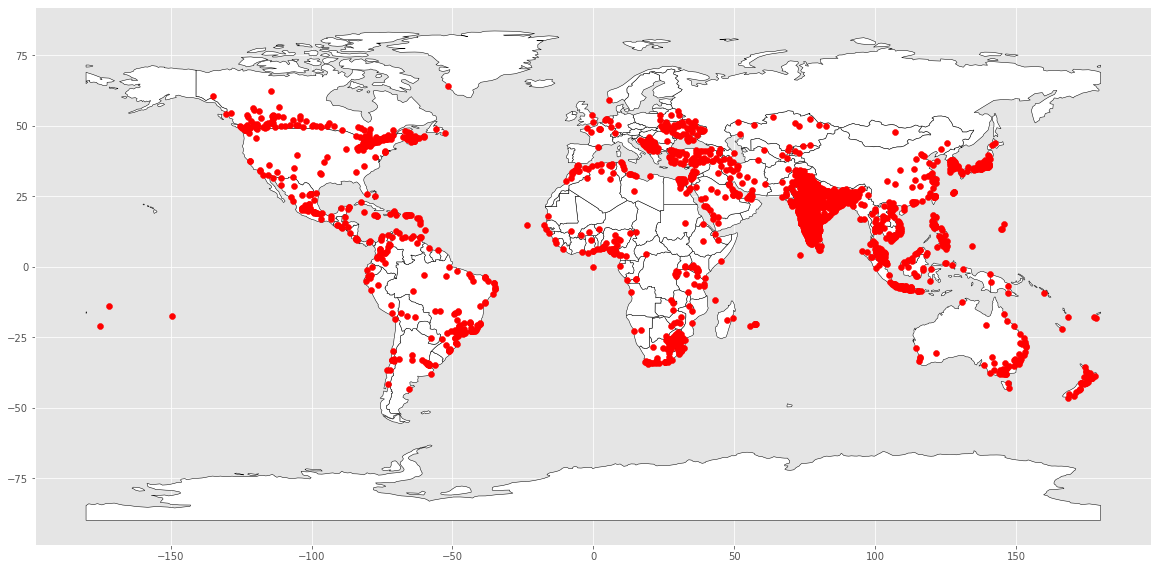

In [12]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
ax = world.plot(color='white', edgecolor='black', figsize=(20,12))

# We can now plot our ``GeoDataFrame``.
gdf.plot(ax=ax, color='red')

plt.show()

In [13]:
from shapely.geometry import Point

In [39]:
df2_top_cities = gdf.sort_values(by="ga:sessions",ascending=False).head(10).copy()

In [40]:
df2_top_cities.reset_index(inplace=True)

In [41]:
df2_top_cities

,index,ga:longitude,ga:latitude,ga:sessions,geometry
0,2461,77.2218,28.6863,290701,POINT (77.22180 28.68630)
1,2524,77.5946,12.9716,223025,POINT (77.59460 12.97160)
2,2649,78.4867,17.3850,206084,POINT (78.48670 17.38500)
3,2972,85.1376,25.5941,191341,POINT (85.13760 25.59410)
4,1803,72.8777,19.0760,189542,POINT (72.87770 19.07600)
5,586,0.0000,0.0000,172662,POINT (0.00000 0.00000)
6,2875,80.9462,26.8467,170860,POINT (80.94620 26.84670)
7,1779,72.5714,23.0225,161849,POINT (72.57140 23.02250)
8,1938,73.8567,18.5204,144234,POINT (73.85670 18.52040)
9,2150,75.8577,22.7196,143845,POINT (75.85770 22.71960)


In [42]:
df3 = geopandas.tools.reverse_geocode(df2_top_cities['geometry'])

In [43]:
df3

,geometry,address
0,POINT (77.22173 28.68632),"Vidhan Sabha, Mahatma Gandhi Road, 110054, Mah..."
1,POINT (77.59423 12.97178),"Cafe Coffee Day Square, Lavelle Road, 560001PH..."
2,POINT (78.48720 17.38382),"Silence zone, Essamia bazar, 500095, Essamia b..."
3,POINT (85.13643 25.59325),"Sparsh Haritage Hospital, Ramesh Colony,kurtho..."
4,POINT (72.87744 19.07593),"SG Barve Marg, Santa Cruz – Chembur Link Road,..."
5,POINT (0.00000 0.00000),Soul Buoy
6,POINT (80.94616 26.84672),"Hazratganj, 226001, Lucknow, Uttar Pradesh, India"
7,POINT (72.57164 23.02289),"Ellisbridge Police Station, Ashram Road, 38000..."
8,POINT (73.85645 18.52015),"ABC, शिवाजी रस्ता, 411001, शिवाजी रस्ता, Pune,..."
9,POINT (75.85771 22.71958),"Mahatma Gandhi Marg, 452001, Indore, Madhya Pr..."


In [44]:
df2_top_5_locations = df2_top_cities.merge(df3, how="left", left_index=True, right_index=True)

In [45]:
df2_top_5_locations

,index,ga:longitude,ga:latitude,ga:sessions,geometry_x,geometry_y,address
0,2461,77.2218,28.6863,290701,POINT (77.22180 28.68630),POINT (77.22173 28.68632),"Vidhan Sabha, Mahatma Gandhi Road, 110054, Mah..."
1,2524,77.5946,12.9716,223025,POINT (77.59460 12.97160),POINT (77.59423 12.97178),"Cafe Coffee Day Square, Lavelle Road, 560001PH..."
2,2649,78.4867,17.3850,206084,POINT (78.48670 17.38500),POINT (78.48720 17.38382),"Silence zone, Essamia bazar, 500095, Essamia b..."
3,2972,85.1376,25.5941,191341,POINT (85.13760 25.59410),POINT (85.13643 25.59325),"Sparsh Haritage Hospital, Ramesh Colony,kurtho..."
4,1803,72.8777,19.0760,189542,POINT (72.87770 19.07600),POINT (72.87744 19.07593),"SG Barve Marg, Santa Cruz – Chembur Link Road,..."
5,586,0.0000,0.0000,172662,POINT (0.00000 0.00000),POINT (0.00000 0.00000),Soul Buoy
6,2875,80.9462,26.8467,170860,POINT (80.94620 26.84670),POINT (80.94616 26.84672),"Hazratganj, 226001, Lucknow, Uttar Pradesh, India"
7,1779,72.5714,23.0225,161849,POINT (72.57140 23.02250),POINT (72.57164 23.02289),"Ellisbridge Police Station, Ashram Road, 38000..."
8,1938,73.8567,18.5204,144234,POINT (73.85670 18.52040),POINT (73.85645 18.52015),"ABC, शिवाजी रस्ता, 411001, शिवाजी रस्ता, Pune,..."
9,2150,75.8577,22.7196,143845,POINT (75.85770 22.71960),POINT (75.85771 22.71958),"Mahatma Gandhi Marg, 452001, Indore, Madhya Pr..."


# OOH Advertising locations

These locations can be used to place OOH adverts such as billboards, koisks, mall advertising, etc...

In [48]:
df2_top_5_locations.to_csv('top_10_locations_of_interest.csv', index=False)